# Import các thư viện cần thiết

In [1]:
import pmdarima as pm
import pandas as pd
import numpy as np
from pmdarima import model_selection
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np


from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.eval_measures import rmse, aic

# Đọc dữ liệu

In [2]:
df_train = pd.read_csv('train.csv', index_col='date')
df_test = pd.read_csv('test.csv',index_col='date')

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 730 entries, 2022-01-01 to 2023-12-31
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       730 non-null    bool   
 1   temperature      730 non-null    float64
 2   new_total_usage  730 non-null    float64
 3   weekday_0        730 non-null    bool   
 4   weekday_1        730 non-null    bool   
 5   weekday_2        730 non-null    bool   
 6   weekday_3        730 non-null    bool   
 7   weekday_4        730 non-null    bool   
 8   weekday_5        730 non-null    bool   
 9   weekday_6        730 non-null    bool   
dtypes: bool(8), float64(2)
memory usage: 22.8+ KB


# Chia tập validate

In [4]:
df_validate = df_train.iloc[-100:, :]
df_train = df_train.iloc[:-100, :]

In [7]:
df_validate.tail()

,is_holiday,temperature,new_total_usage,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,,,
2023-12-27,False,22.45,3542.0,False,False,True,False,False,False,False
2023-12-28,False,23.40,3432.0,False,False,False,True,False,False,False
2023-12-29,False,24.00,3311.0,False,False,False,False,True,False,False
2023-12-30,False,23.62,1452.0,False,False,False,False,False,True,False
2023-12-31,False,23.55,1078.0,False,False,False,False,False,False,True


# Chuẩn bị dữ liệu để dự đoán

## Chuyển giá trị True/False về 1/0

In [8]:
def convert_columns_to_int(df, weekday_cols_prefix='weekday_', holiday_col='is_holiday', num_weekdays=6):
    """
    Chuyển đổi các cột 'weekday' và 'is_holiday' của DataFrame sang kiểu dữ liệu int.

    Tham số:
    - df: DataFrame cần chuyển đổi.
    - weekday_cols_prefix: Tiền tố của các cột 'weekday'. Mặc định là 'weekday_'.
    - holiday_col: Tên cột ngày lễ cần chuyển đổi. Mặc định là 'is_holiday'.
    - num_weekdays: Số lượng cột 'weekday' cần chuyển đổi (mặc định là 6).
    
    Trả về:
    - DataFrame với các cột đã được chuyển sang kiểu int.
    """
    
    # Chuyển đổi các cột weekday_{i} thành int
    for i in range(0, num_weekdays + 1):  # Lặp từ 1 tới num_weekdays
        df[f'{weekday_cols_prefix}{i}'] = df[f'{weekday_cols_prefix}{i}'].astype(int)
    
    # Chuyển đổi cột is_holiday thành int
    df[holiday_col] = df[holiday_col].astype(int)
    
    return df

In [9]:
df_train = convert_columns_to_int(df=df_train)
df_validate = convert_columns_to_int(df=df_validate)
df_test = convert_columns_to_int(df=df_test)

## Chuyển index về datetime

In [11]:
df_train.index = pd.to_datetime(df_train.index)
df_validate.index = pd.to_datetime(df_validate.index)
df_test.index = pd.to_datetime(df_test.index)

## Chuyển freq

In [12]:
df_train = df_train.asfreq('D')  
df_validate = df_validate.asfreq('D')  
df_test = df_test.asfreq('D')  

## Chia tập X, y

In [13]:
X_train = df_train.iloc[:,:-1]
y_train = df_train.iloc[:,-1]
X_validate = df_validate.iloc[:,:-1]
y_validate = df_validate.iloc[:,-1]
X_test = df_test.iloc[:,:-1]
y_test = df_test.iloc[:,-1]


In [14]:
X_train.shape

(630, 9)

In [15]:
y_train.shape

(630,)

In [16]:
X_test.shape

(190, 9)

In [17]:
y_test.shape

(190,)

# Seasonal components

In [20]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 630 entries, 2022-01-01 to 2023-09-22
Freq: D
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       630 non-null    int32  
 1   temperature      630 non-null    float64
 2   new_total_usage  630 non-null    float64
 3   weekday_0        630 non-null    int32  
 4   weekday_1        630 non-null    int32  
 5   weekday_2        630 non-null    int32  
 6   weekday_3        630 non-null    int32  
 7   weekday_4        630 non-null    int32  
 8   weekday_5        630 non-null    int32  
 9   weekday_6        630 non-null    int32  
dtypes: float64(2), int32(8)
memory usage: 34.5 KB


In [21]:
ts_decomposition = seasonal_decompose(x=df_train['new_total_usage'], model='additive')
trend_estimate = ts_decomposition.trend
seasonal_estimate = ts_decomposition.seasonal
residual_estimate = ts_decomposition.resid

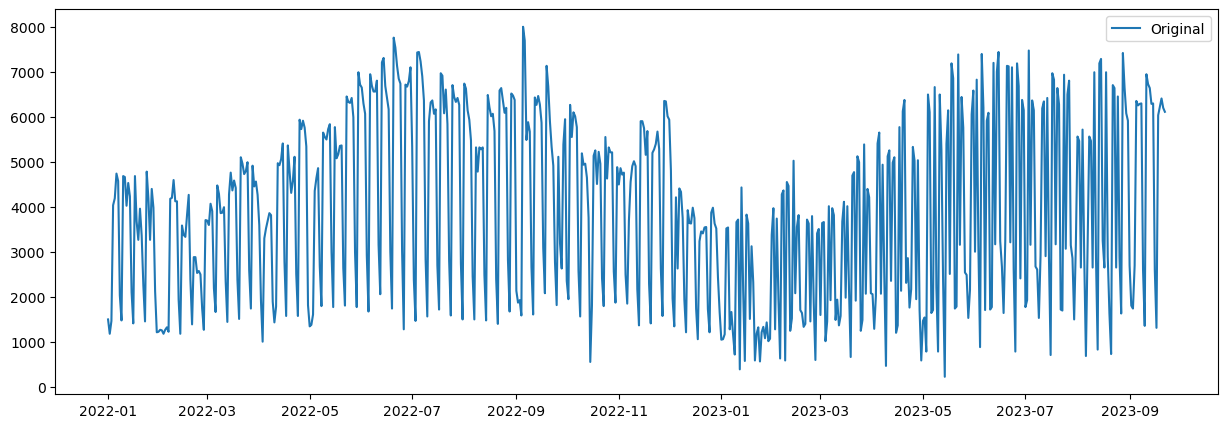

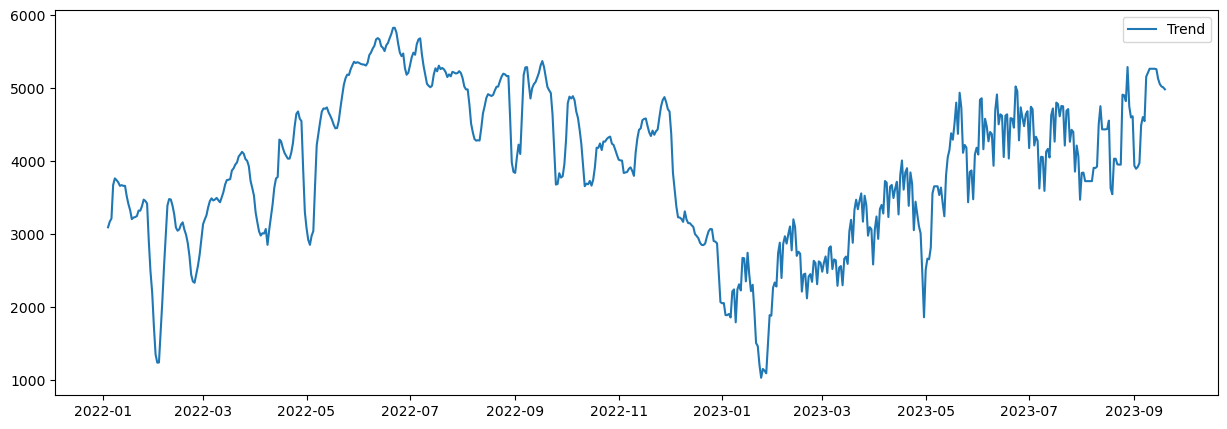

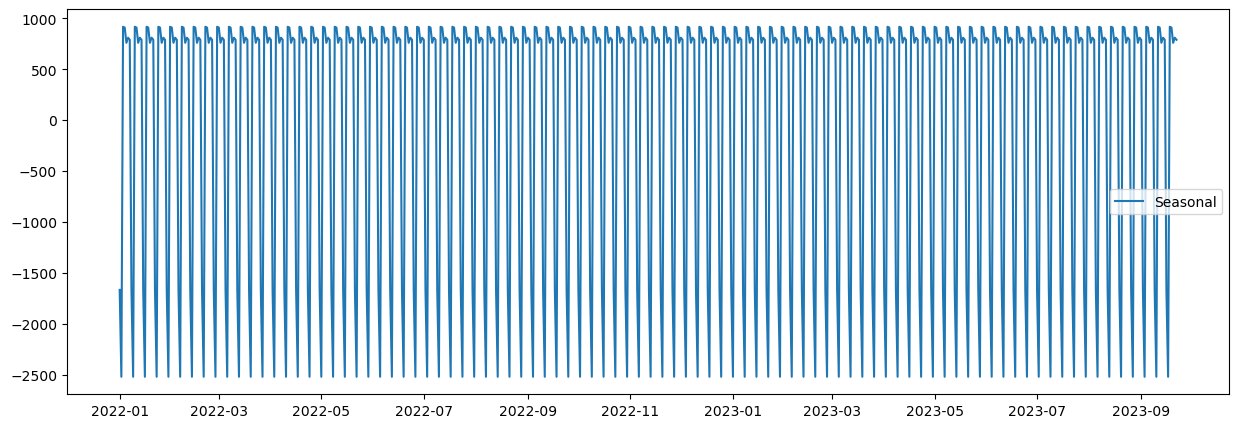

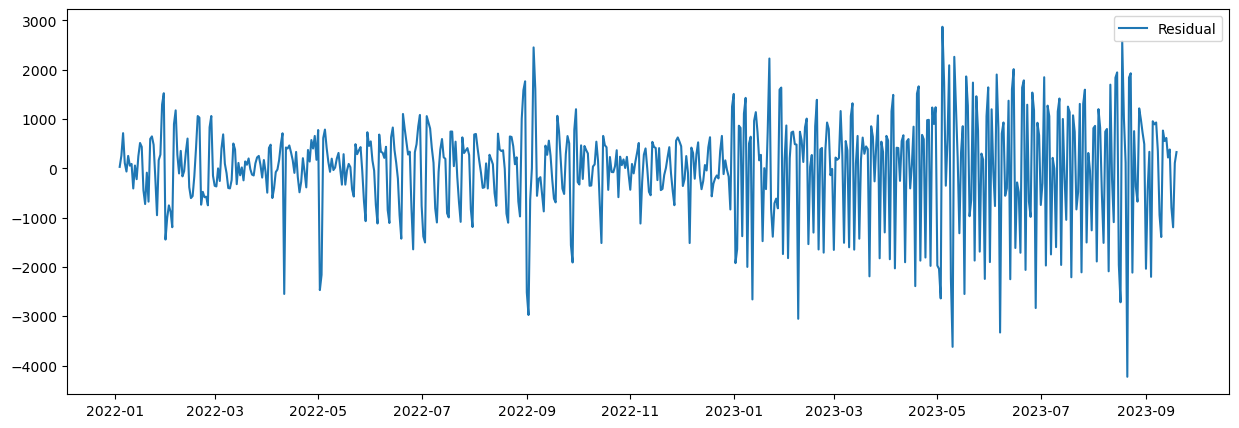

In [22]:
plt.figure(figsize=(15,5))
plt.plot(df_train['new_total_usage'], label='Original')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(trend_estimate, label='Trend')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(seasonal_estimate, label='Seasonal')
plt.legend()

plt.figure(figsize=(15,5))
plt.plot(residual_estimate, label='Residual')
plt.legend()

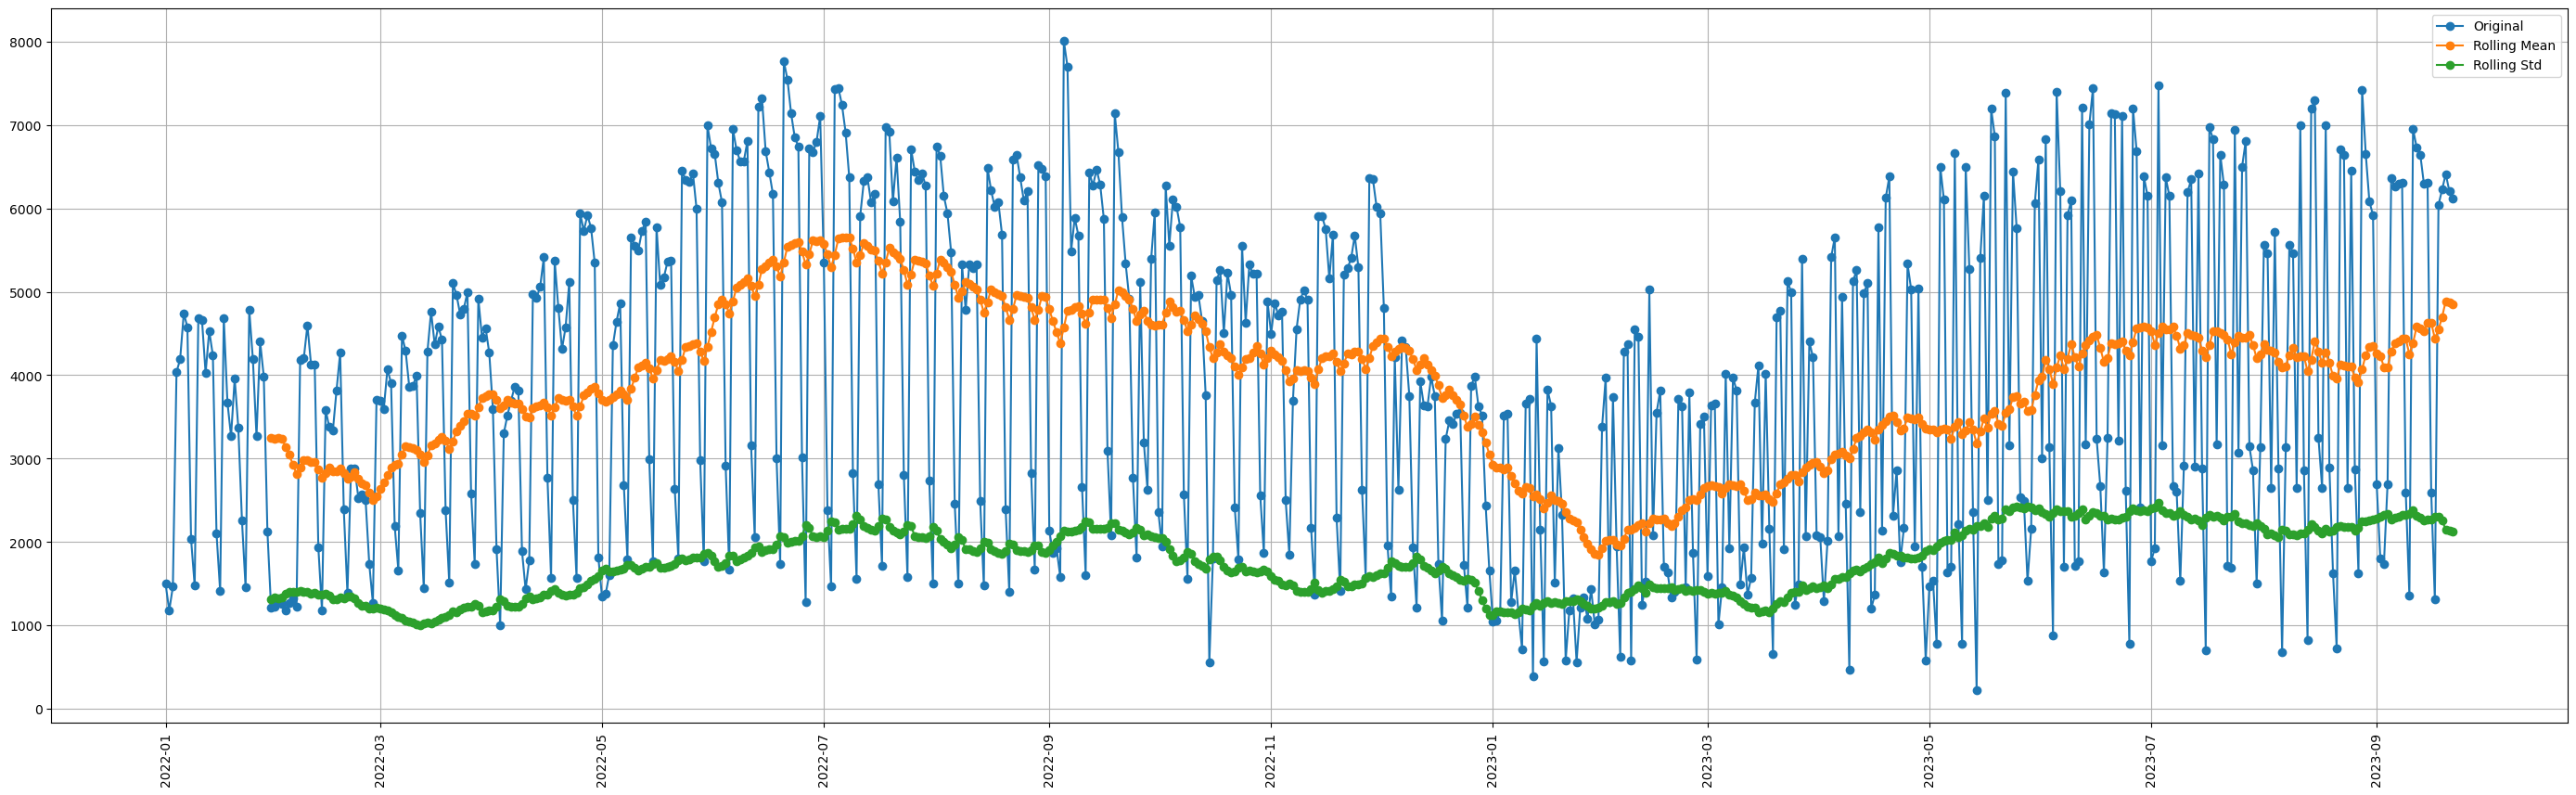

In [23]:
plt.figure(figsize=(35,10))
plt.grid()
plt.plot(df_train['new_total_usage'], marker='o', label='Original')
plt.plot(df_train['new_total_usage'].rolling(window=30).mean(), marker='o', label='Rolling Mean')
plt.plot(df_train['new_total_usage'].rolling(window=30).std(), marker='o', label='Rolling Std')
plt.xticks(rotation=90)
plt.legend()
plt.show()

# Kiểm tra tính stationary:
- Time series được coi là stationary khi constant mean, constant variance và constant autocorrelation

In [24]:
from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, signif=0.05, name='', verbose=False):
    

    result = adfuller(series.values)
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)

    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print("\u001b[32mStationary\u001b[0m")
    else:
        print("\x1b[31mNon-stationary\x1b[0m")

In [25]:
for name, column in df_train.items():
    check_stationarity(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "is_holiday" 
    -----------------------------------------------
ADF Statistic: -9.870513
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary


    Augmented Dickey-Fuller Test on "temperature" 
    -----------------------------------------------
ADF Statistic: -2.100808
p-value: 0.244190
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Non-stationary


    Augmented Dickey-Fuller Test on "new_total_usage" 
    -----------------------------------------------
ADF Statistic: -1.352065
p-value: 0.605029
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Non-stationary


    Augmented Dickey-Fuller Test on "weekday_0" 
    -----------------------------------------------
ADF Statistic: -21499999661967104.000000
p-value: 0.000000
Critical Values:
	1%: -3.441
	5%: -2.866
	10%: -2.569
Stationary


    Augmented Dickey-Fuller Test on "weekday_1" 
    -----------------------------------------------
ADF Statistic: -136970

## Nhận xét:
- Trừ new_total_usage và temperature thì các feature còn lại đều là stationary

# Fit model

In [21]:
X_train.head()

,is_holiday,temperature,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6
date,,,,,,,,
2024-03-30,0,28.12,0,0,0,0,1,0
2023-07-12,0,31.07,0,1,0,0,0,0
2024-02-14,1,23.25,0,1,0,0,0,0
2023-02-16,0,22.06,0,0,1,0,0,0
2022-05-20,0,26.62,0,0,0,1,0,0


In [47]:
arima = pm.auto_arima(y_train,X=X_train,m=31, seasonal=False, trace=2,d=None,start_p=0, start_q=0,  max_p=12, max_q=12,   D=None,        
                    stationary=True,test='adf', error_action='trace')

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\pmdarima\arima\_validation.py:62: UserWarning: m (31) set for non-seasonal fit. Setting to 0
  warnings.warn("m (%i) set for non-seasonal fit. Setting to 0" % m)


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10508.982, Time=0.38 sec
First viable model found (10508.982)
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10517.241, Time=0.18 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10516.947, Time=0.49 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=10514.224, Time=0.42 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10519.240, Time=0.53 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 2.092 seconds


In [48]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  619
Model:                        SARIMAX   Log Likelihood               -5244.491
Date:                Fri, 06 Sep 2024   AIC                          10508.982
Time:                        15:33:37   BIC                          10553.263
Sample:                             0   HQIC                         10526.195
                                - 619                                         
Covariance Type:                  opg                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
intercept   -1089.8733    421.146     -2.588      0.010   -1915.305    -264.442
is_holiday  -2251.3419    240.248     -9.371      0.000   -2722.219   -1780.465
temperature   235.4304     14.874     15.828      0.000     206.278     264.583
weekday_1    -250.3365    155.492     -1.610      0.107    -555.096      54.423
weekday_2    -368.4707    142.204     -2.591      0.010    -647.185     -89.757
weekday_3    -427.9899    149.232     -2.868      0.004    -720.479    -135.501
weekday_4    -327.1364    163.793     -1.997      0.046    -648.164      -6.109
weekday_5   -2710.4851    237.153    -11.429      0.000   -3175.296   -2245.674
weekday_6   -3636.6263    217.427    -16.726      0.000   -4062.775   -3210.478
sigma2       1.328e+06   7.98e+04     16.645      0.000    1.17e+06    1.48e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):               306.01
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               0.84   Skew:                            -1.36
Prob(H) (two-sided):                  0.22   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [49]:
arima.params

<bound method ARIMA.params of ARIMA(order=(0, 0, 0), scoring_args={}, suppress_warnings=True)>

In [50]:
pred=arima.predict(n_periods=100, X=X_validate, alpha=0.05)
pred

c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\ASUS\.conda\envs\time_series_env\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


619    1300.518002
620       5.650931
621    4887.815810
622    3713.399750
623    5007.885302
          ...     
714    1566.554327
715    4283.802853
716    5356.322259
717    1575.971542
718    4498.044495
Length: 100, dtype: float64

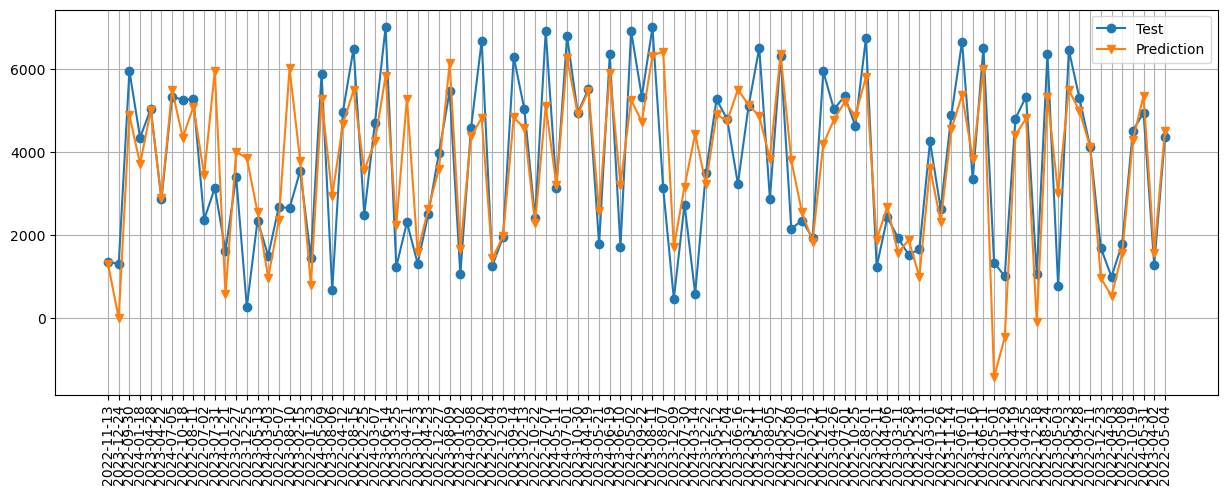

In [51]:
plt.figure(figsize=(15,5))
plt.grid()
#plt.plot(data['Period'][:-10], train['GDP_GROWTH'], marker='o', label='Train')
plt.plot(df_validate.index,y_validate, marker='o', label='Test')
plt.plot(df_validate.index,pred, marker='v', label='Prediction')
plt.legend()
plt.xticks(rotation=90)
plt.show()

In [52]:
mape=mean_absolute_percentage_error(y_validate, pred)
print("Mean Absolute Percentage Error", mape)


Mean Absolute Percentage Error 0.544658728935132


In [45]:
mse=mean_squared_error(y_validate, pred)
print("Mean Squared Error",mse)

Mean Squared Error 1425492.9657656604


In [46]:
print("RMSE", (mse)**0.5)

RMSE 1193.9401014144973


In [33]:
print("AIC values {}".format(arima.aic()))

AIC values 10508.981541838211


# ARIMA

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose

# decompose the time series into its trend, seasonal and residuals components
result_decompose = seasonal_decompose(df_train['new_total_usage'], model='additive')


ValueError: This function does not handle missing values

In [63]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 899 entries, 2022-01-22 to 2024-07-08
Freq: D
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   is_holiday       619 non-null    float64
 1   temperature      619 non-null    float64
 2   weekday_1        619 non-null    float64
 3   weekday_2        619 non-null    float64
 4   weekday_3        619 non-null    float64
 5   weekday_4        619 non-null    float64
 6   weekday_5        619 non-null    float64
 7   weekday_6        619 non-null    float64
 8   new_total_usage  619 non-null    float64
dtypes: float64(9)
memory usage: 70.2 KB


In [ ]:
trend     = result_decompose.trend
seasonal  = result_decompose.seasonal
residuals = result_decompose.resid
# plot every component
plt.figure(figsize=(20,10))
plt.subplot(311)
plt.plot(trend)
plt.title('trend')
plt.subplot(312)
plt.plot(seasonal)
plt.title('seasonality')
plt.subplot(313)
plt.plot(residuals)
plt.title('residuals')